# <font color='red'><b> SIFT OPERATOR </b></font>


### Credits: Hands-on Image Processing with Python, Chapter 7 - Author: Sandipan Dey


In [1]:
#@title ▶️ Base dir setup
import os, sys

# check if hosted (Google VM) or running on local server
if 'google.colab' in sys.modules:
  #@markdown Google Drive root folder - hosted by Google VM (adapt to your local paths)
  from google.colab import drive
  drive.mount('/content/drive', force_remount=False)
  base_dir = 'infoMM/' #@param {type: "string"}
  base_dir  = os.path.join('/content/drive/MyDrive/', base_dir)
  #!pip install pillow  --upgrade
else:
  #@markdown Path to local folder on PC (adapt to your local paths)
  base_dir  =  '/Users/raffaella/GoogleDrive/infoMM/'  #@param {type: "string"}

# dirs
wav_dir = 'data/wav/'
mp3_dir = 'data/mp3/'
img_dir = 'data/img/'
vid_dir = 'data/video/'
out_dir = 'output/'

# move to base_dir 
os.chdir(base_dir)
print("Current dir:", os.getcwd())

Mounted at /content/drive
Current dir: /content/drive/.shortcut-targets-by-id/0B_7SDsuxT1O9eTJ4cFhFdkdaMlk/infoMM


In [2]:
!apt-get -qq install -y libsm6 libxext6
!pip install -q -U opencv-python

In [3]:
import numpy as np
import cv2 
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans
from scipy.spatial import distance_matrix
import pickle
import math
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage import img_as_float, img_as_ubyte

cv2.__version__

'4.6.0'

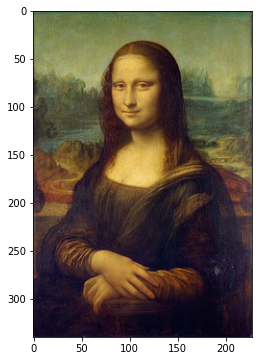

In [4]:
 
# load an example image 
img = imread(img_dir + 'monalisa.jpg')# 'flowers.png') #'flowers.jpg')  

# show image
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.show()

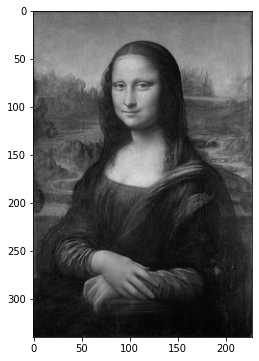

In [5]:
gray = img_as_ubyte(rgb2gray(img))
# show image
plt.figure(figsize=(6,6))
plt.imshow(gray, cmap='gray', vmin=0, vmax=255)
plt.show()

## <font color='red'><b>- SIFT in OpenCV</b></font>


So now let’s see SIFT functionalities available in OpenCV. Let’s start with keypoint detection and draw them. First we have to construct a SIFT object. We can pass different parameters to it which are optional and they are well explained in docs.

https://docs.opencv.org/master/da/df5/tutorial_py_sift_intro.html


**1. create the SIFT object:**
 
`sift = cv2.SIFT_create()` https://docs.opencv.org/4.4.0/d7/d60/classcv_1_1SIFT.html

It has several parameters, but interesting to us:


- *nfeatures:*	The number of best features to retain (if 0, it returns all the kp it found). The features are ranked by their scores (measured in SIFT algorithm as the local contrast)
- *nOctaveLayers:*	The number of layers in each octave. 3 is the value used in D. Lowe paper. The number of octaves is computed automatically from the image resolution.

- *contrastThreshold:*	The contrast threshold used to filter out weak features in semi-uniform (low-contrast) regions. The larger the threshold, the less features are produced by the detector.
- *edgeThreshold:*	The threshold used to filter out edge-like features. Note that the its meaning is different from the contrastThreshold. The larger the edgeThreshold, the less features are filtered out (more features are retained).

- *sigma:*	The sigma of the Gaussian applied to the input image at the octave #0. If your image is captured with a weak camera with soft lenses, you might want to reduce the number.


In [26]:
#DEFAULT PARAMETERS VALUES (EQUIVALENT TO CALL sift = cv2.SIFT_create() ):
sift = cv2.SIFT_create(nfeatures = 0, nOctaveLayers = 3, contrastThreshold = 0.1, edgeThreshold = 10, sigma = 2)	 

##### <font color='blue'><b>-  EXERCISE 1: </b></font>
Modify the contrastThreshold, the edgeThreshold, and the sigma parameters, and observe the variation in keypoint detection

**2. Keypoint detection**

`kp = sift.detect(gray,None)`

`kp` is the list of the detected keypoints, eqch one with the field; 
- *pt*:	x & y coordinates of the keypoint

- *size*:	keypoint diameter

- *angle*:	keypoint orientation

- *response*:	keypoint detector response on the keypoint (that is, strength of the keypoint)

- *octave*:	pyramid octave in which the keypoint has been detected

- *class_id*:	object id

In [19]:
def print_KP_info(kp, i):
  print('Keypoint coordinates: '+ str(kp[i].pt)) 
  print('Keypoint size: '+ str(kp[i].size))  
  print('Keypoint orientation: '+ str(kp[i].angle))  
  print('Keypoint response: '+ str(kp[i].response))   

In [20]:
#detection
kp = sift.detect(gray, None)
print('Detected KP: '+ str(len(kp)));

KP_i= 0
print_KP_info(kp, KP_i)

Detected KP: 25
Keypoint coordinates: (62.557716369628906, 74.09197998046875)
Keypoint size: 12.968049049377441
Keypoint orientation: 208.30166625976562
Keypoint response: 0.03690120950341225


##### <font color='blue'><b>-  EXERCISE 2: </b></font>
 
Given the list of keypoint, detect the one with the strongest response, and print all the corresponding information using the function `print_KP_info(kp, i)`

In [21]:
#detect the keypoint with the strongest response
max_response = float('-Inf')
max_pos = -1;

for i in range(len(kp)):
  val = kp[i].response;
  if val > max_response:
      max_response = val;
      max_pos = i;

print_KP_info(kp, max_pos)


Keypoint coordinates: (109.964599609375, 164.1923065185547)
Keypoint size: 33.80164337158203
Keypoint orientation: 242.32489013671875
Keypoint response: 0.08926760405302048


In [22]:
#or better:
val= [kp[i].response for i in range(len(kp))];
kp_max_resp = np.argmax(val)

print_KP_info(kp, kp_max_resp)

Keypoint coordinates: (109.964599609375, 164.1923065185547)
Keypoint size: 33.80164337158203
Keypoint orientation: 242.32489013671875
Keypoint response: 0.08926760405302048


##### <font color='blue'><b>-  EXERCISE 3: </b></font>
 
Given the list of keypoint, detect the one with the largest size, and print all the corresponding information using the function `print_KP_info(kp, i)`

In [23]:
val= [kp[i].size for i in range(len(kp))];
kp_max_size = np.argmax(val)

print_KP_info(kp, kp_max_size)

Keypoint coordinates: (146.93972778320312, 105.14360046386719)
Keypoint size: 39.41347885131836
Keypoint orientation: 321.6702575683594
Keypoint response: 0.043391838669776917


**3. Keypoint descriptor**

`keypoints, des = sift.compute(image, keypoints)`
 
Parameters:
- *image*:	Image.
- *keypoints*:	[List] Input collection of keypoints. Keypoints for which a descriptor cannot be computed are removed. Sometimes new keypoints can be added, for example: SIFT duplicates keypoint with several dominant orientations (for each orientation).
- *descriptors*:	[array of array] Computed descriptors. In the second variant of the method descriptors[i] are descriptors computed for a keypoints[i]. Row j is the keypoints (or keypoints[i]) is the descriptor for keypoint j-th keypoint.


In [24]:
# compute the keypoint description 
kp, des = sift.compute(gray, kp)

print("Descrpitor dimension: " + str(np.squeeze(des[0].shape)))
print(des[0])

#OR
#detection and description in one step
kp, des = sift.detectAndCompute(gray,None)

Descrpitor dimension: 128
[ 19.  84.  14.   2.   0.  54.  32.   3.  31.  35.  15.   7.   2.   2.
  11.  38.  11.   0.   0.   0.   0.   0.  43.  74.   1.   0.   0.   0.
   0.   6.  74.  62.  15.   6.   1.   1.  38. 132.  65.  22. 132.   9.
   0.   0.   9.  43.  60. 132.  21.   1.   0.   1.   0.   6. 132. 119.
   0.   0.   1.   4.   1.   3. 132.  87.  11.   2.   8.   8.  75. 132.
  36.  24. 132.  29.   1.   0.  24. 122.  29.  50.  81.  29.  19.  17.
   1.   4.  39.  18.   0.   0.  21.  48.   1.   1.  16.   6.  33.  38.
  45.  29.  27.  47.  23.  33.  65.  18.  16.  43.  59.  71.  12.  11.
  42.  22.  32.  27.   0.   0.   0.   2.   0.   0.  26.  52.   0.   0.
   0.   0.]


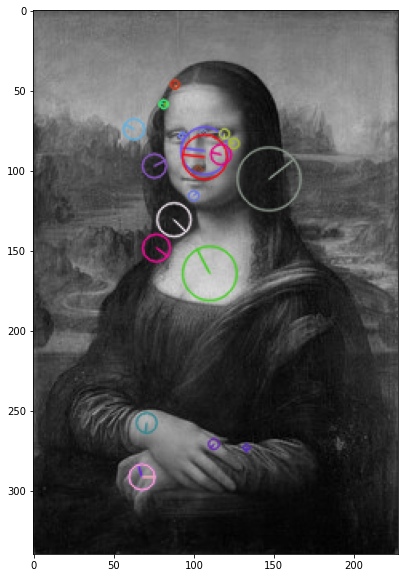

In [25]:
#draw the keypoints on an image
imgKP=cv2.drawKeypoints(gray,kp,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#img=cv2.drawKeypoints(gray,kp,img) #simple visualization

plt.figure(figsize=(30,10))
plt.imshow(imgKP, cmap='gray', vmin=0, vmax=255)
plt.show()

##### <font color='blue'><b>-  EXERCISE 3: </b></font>
 
Given the keypoint with the maximum response (keypoint: 'kp_max_resp') plot only it using opportunely the function cv2.drawKeypoints.
do the same for the kp with max size


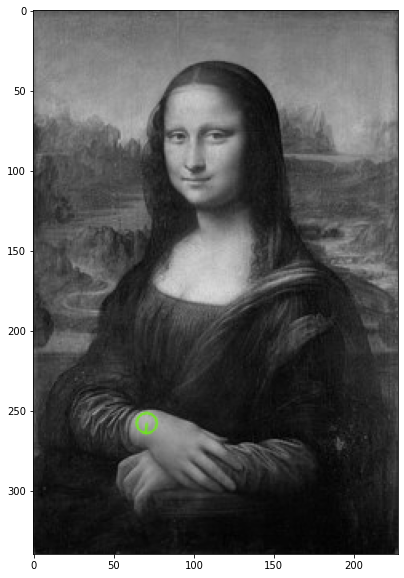

In [ ]:
imgKP_strongest = cv2.drawKeypoints(gray,[kp[kp_max_resp]],img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#imgKP_strongest = cv2.drawKeypoints(gray,[kp[kp_max_resp]],None,color=(0,255,0))
plt.figure(figsize=(20,10))
plt.imshow(imgKP_strongest)
plt.show()